#Подключаем библиотеки

In [ ]:
!pip install keras==2.0 -q 

ERROR: Could not find a version that satisfies the requirement tensorflow==2.0.0rc0 (from versions: 1.13.1, 1.13.2, 1.14.0, 1.15.0, 1.15.2, 1.15.3, 1.15.4, 1.15.5, 2.0.0, 2.0.1, 2.0.2, 2.0.3, 2.0.4, 2.1.0, 2.1.1, 2.1.2, 2.1.3, 2.1.4, 2.2.0rc0, 2.2.0rc1, 2.2.0rc2, 2.2.0rc3, 2.2.0rc4, 2.2.0, 2.2.1, 2.2.2, 2.2.3, 2.3.0rc0, 2.3.0rc1, 2.3.0rc2, 2.3.0, 2.3.1, 2.3.2, 2.3.3, 2.3.4, 2.4.0rc0, 2.4.0rc1, 2.4.0rc2, 2.4.0rc3, 2.4.0rc4, 2.4.0, 2.4.1, 2.4.2, 2.4.3, 2.4.4, 2.5.0rc0, 2.5.0rc1, 2.5.0rc2, 2.5.0rc3, 2.5.0, 2.5.1, 2.5.2, 2.6.0rc0, 2.6.0rc1, 2.6.0rc2, 2.6.0, 2.6.1, 2.6.2, 2.7.0rc0, 2.7.0rc1, 2.7.0, 2.8.0rc0, 2.8.0rc1)
ERROR: No matching distribution found for tensorflow==2.0.0rc0


In [9]:
import keras
import tensorflow as tf
print(keras.__version__)
print(tf.__version__)

2.0.0
2.5.2


In [ ]:
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import numpy as np
from PIL import Image
from tqdm import tqdm
import os 
import time
import matplotlib.pyplot as plt
from google.colab import files 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.0
except:
    print("Note: not using Google CoLab")
    COLAB = False

Mounted at /content/drive
Note: using Google CoLab
`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.0`. This will be interpreted as: `2.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


#Подготавливаем дата-сет

In [ ]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

In [ ]:
generate_res = 3 
generate_square = 32 * generate_res 
image_chanels = 3
images_rows = 4
images_cols = 7
margin = 16
seed_size = 100

epoch = 50
batch_size = 32
bufer_size = 60000

print(f"Will generate {generate_square}px square images.")

Will generate 96px square images.


In [ ]:
DATA_PATH='/content/drive/My Drive/Aero_base/'
training_binary_path = os.path.join(DATA_PATH,f'training_data_{generate_square}_{generate_square}.np')
print(f"Looking for file: {training_binary_path}")

if not os.path.isfile(training_binary_path):
  start = time.time()
  print("Loading training images...")

  training_data = []
  air_path = os.path.join(DATA_PATH,'Air')
  for filename in tqdm(os.listdir(air_path)):
    path = os.path.join(air_path,filename)
    image = Image.open(path).resize((generate_square,generate_square),Image.ANTIALIAS)
    training_data.append(np.asarray(image))

  training_data = np.reshape(training_data,(-1,generate_square,generate_square,image_chanels))
  training_data = training_data.astype(np.float32)
  training_data = training_data / 127.5 - 1.
  print("Saving training image binary...")

  np.save(training_binary_path,training_data)
  elapsed = time.time()-start
  print (f'Image preprocess time: {hms_string(elapsed)}')
else:
  print("Loading previous training pickle...")
  training_data = np.load(training_binary_path)

Looking for file: /content/drive/My Drive/Aero_base/training_data_96_96.np
Loading training images...


100%|██████████| 1000/1000 [07:46<00:00,  2.14it/s]


Saving training image binary...
Image preprocess time: 0:07:53.61


In [ ]:
training_data.shape

(1000, 96, 96, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


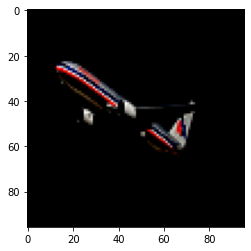

In [ ]:
plt.imshow(training_data[0])

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(training_data).shuffle(bufer_size).batch(batch_size)

#Генератор

In [ ]:
def generator_conditional:(seed_size, channels):
  generator = Sequential()
  generator.add(Dense(4*4*256,activation="relu",input_dim=seed_size))
  generator.add(Reshape((4,4,256)))
  generator.add(UpSampling2D())
  generator.add(Conv2D(256,kernel_size=3,padding="same"))
  generator.add(BatchNormalization(momentum=0.8))
  generator.add(Activation("relu"))
  generator.add(UpSampling2D())
  generator.add(Conv2D(256,kernel_size=3,padding="same"))
  generator.add(BatchNormalization(momentum=0.8))
  generator.add(Activation("relu"))
  generator.add(UpSampling2D())
  generator.add(Conv2D(128,kernel_size=3,padding="same"))
  generator.add(BatchNormalization(momentum=0.8))
  generator.add(Activation("relu"))

  if generate_res>1:
    generator.add(UpSampling2D(size=(generate_res,generate_res)))
    generator.add(Conv2D(128,kernel_size=3,padding="same"))
    generator.add(BatchNormalization(momentum=0.8))
    generator.add(Activation("relu"))

  generator.add(Conv2D(channels,kernel_size=3,padding="same"))
  generator.add(Activation("tanh"))

  return generator

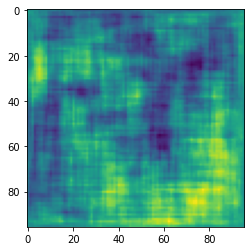

In [ ]:
generator = generator_conditional(seed_size, image_chanels)
noise = tf.random.normal([1, seed_size])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0])

#Дискриминатор

In [ ]:
def discriminator_conditional(image_shape):
  discriminator = Sequential()
  discriminator.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, padding="same"))
  discriminator.add(LeakyReLU(alpha=0.2))
  discriminator.add(Dropout(0.25))
  discriminator.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
  discriminator.add(ZeroPadding2D(padding=((0,1),(0,1))))
  discriminator.add(BatchNormalization(momentum=0.8))
  discriminator.add(LeakyReLU(alpha=0.2))
  discriminator.add(Dropout(0.25))
  discriminator.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
  discriminator.add(BatchNormalization(momentum=0.8))
  discriminator.add(LeakyReLU(alpha=0.2))
  discriminator.add(Dropout(0.25))
  discriminator.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
  discriminator.add(BatchNormalization(momentum=0.8))
  discriminator.add(LeakyReLU(alpha=0.2))
  discriminator.add(Dropout(0.25))
  discriminator.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
  discriminator.add(BatchNormalization(momentum=0.8))
  discriminator.add(LeakyReLU(alpha=0.2))
  discriminator.add(Dropout(0.25))
  discriminator.add(Flatten())
  discriminator.add(Dense(1, activation='sigmoid'))

  return discriminator

In [ ]:
image_shape = (generate_square,generate_square,image_chanels)
discriminator = discriminator_conditional(image_shape)
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.5003634]], shape=(1, 1), dtype=float32)


#Сохранение сгенерированных картинок

In [ ]:
def save_images(cnt,noise):
  image_array = np.full((margin + (images_rows * (generate_square+margin)), margin + (images_cols * (generate_square+margin)), image_chanels), 255, dtype=np.uint8)
  generated_images = generator.predict(noise)
  generated_images = 0.5 * generated_images + 0.5
  image_count = 0
  for row in range(images_rows):
    for col in range(images_cols):
      r = row * (generate_square+16) + margin
      c = col * (generate_square+16) + margin
      image_array[r:r+generate_square,c:c+generate_square] = generated_images[image_count] * 255
      image_count += 1
        
  output_path = os.path.join(DATA_PATH,'output')
  if not os.path.exists(output_path):
    os.makedirs(output_path)
  
  filename = os.path.join(output_path,f"train-{cnt}.png")
  im = Image.fromarray(image_array)
  im.save(filename)

#Обучение GANC

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)

In [ ]:
@tf.function
def train_step(images):
  seed = tf.random.normal([batch_size, seed_size])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(seed, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
  return gen_loss,disc_loss

In [ ]:
def train(dataset, epochs):
  fixed_seed = np.random.normal(0, 1, (images_rows * images_cols, seed_size))
  start = time.time()

  for epoch in range(epochs):
    epoch_start = time.time()

    gen_loss_list = []
    disc_loss_list = []

    for image_batch in dataset:
      t = train_step(image_batch)
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])

    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)

    epoch_elapsed = time.time()-epoch_start
    print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss},'f' {hms_string(epoch_elapsed)}')
    save_images(epoch,fixed_seed)

  elapsed = time.time()-start
  print (f'Training time: {hms_string(elapsed)}')

In [ ]:
train(train_dataset, epoch)

Epoch 1, gen loss=2.021796703338623,disc loss=0.871226966381073, 0:08:00.10
Epoch 2, gen loss=3.053983449935913,disc loss=0.8878719806671143, 0:08:01.78
Epoch 3, gen loss=2.869032382965088,disc loss=0.9807941913604736, 0:07:58.10
Epoch 4, gen loss=3.0392537117004395,disc loss=0.8624981641769409, 0:07:57.18
Epoch 5, gen loss=3.0886709690093994,disc loss=1.2081502676010132, 0:07:58.72
Epoch 6, gen loss=3.2806990146636963,disc loss=0.8643315434455872, 0:08:00.51
Epoch 7, gen loss=3.670931100845337,disc loss=0.7446281313896179, 0:08:00.02
Epoch 8, gen loss=3.466620922088623,disc loss=0.6900025606155396, 0:07:56.69
Epoch 9, gen loss=3.9279544353485107,disc loss=0.7461276650428772, 0:07:56.86
Epoch 10, gen loss=3.0123562812805176,disc loss=1.245131254196167, 0:07:57.51
Epoch 11, gen loss=3.030834197998047,disc loss=1.1058933734893799, 0:07:57.62
Epoch 12, gen loss=3.07509446144104,disc loss=0.9907189607620239, 0:07:57.53
Epoch 13, gen loss=3.350841760635376,disc loss=0.805560290813446, 0:07:

Сгенерированные картинки были сохранены по следующему пути: '/content/drive/My Drive/Aero_base/output' и доступны по ссылке: https://drive.google.com/drive/folders/1CtjjMA_d76Uhivk4cx4qT1jdTNoysZKP